In [8]:
import os
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
from string import digits
from google.colab import files
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import datetime
import os
from google.colab import data_table
data_table.enable_dataframe_formatter()
import functools
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import random

plt.rcParams["figure.figsize"] = [12, 7]


class stock_positions:
  df_inp = pd.DataFrame()
  df_full = pd.DataFrame()
  df_dateLim = pd.DataFrame()

  dates_range = []
  selector = None

  def __init__(self, filename='', trades_filter=10):
    if os.path.exists(filename):
      self.df_inp = pd.read_csv(filename)
    else:
      uploaded = files.upload()
      filename = list(uploaded.keys())[0]
      self.df_inp = pd.read_csv(filename)
    ss_i = 0
    self.df_inp['entrydate'], self.df_inp['closedate'] = pd.to_datetime(self.df_inp['entrydate'], utc=True), pd.to_datetime(self.df_inp['closedate'], utc=True)

    # Make an int index column
    self.df_inp['idxdate'] = self.df_inp['entrydate'].dt.strftime("%y%m%d%H%M%S").astype(int)
    self.df_inp.sort_values('idxdate', inplace=True)
    self.df_inp.set_index('idxdate', inplace=True)

    # Clean the symbol column
    clean_symbols = lambda x: re.search(r"[a-z]*", x, re.IGNORECASE).group()
    self.df_inp['symbols'] = self.df_inp['symbol'].apply(clean_symbols)

    # Replace less-traded stocks as 'OTHER'
    self.df_inp['full_symbols'] = self.df_inp['symbols']  # Keep a copy of the column
    _tmp = self.df_inp['symbols'].value_counts().reset_index()
    other_stocks = _tmp[_tmp['symbols']<trades_filter]['index'].tolist()
    for stk in other_stocks:
      self.df_inp['symbols'].replace({stk: 'OTHER'}, inplace=True)
    
    # Add time-in-trade column and handle faulty rows, replacing Faulty Values with default (1) or removing the respective rows
    self.df_inp['time-in-trade'] = (self.df_inp['closedate'] - self.df_inp['entrydate']).astype('timedelta64[s]')
    self.df_inp = self.df_inp[self.df_inp['time-in-trade'] > 0]
    #self.df_inp['time-in-trade'][ self.df_inp['time-in-trade']<=0 ] = 1

    # Make a working copy, and delete extra columns in inp to make total<=20 (for colab display)
    self.df_full = self.df_inp.copy()
    self.df_inp.drop('symbol', inplace=True, axis=1)
    self.df_inp.drop('full_symbols', inplace=True, axis=1)

    # Add a rates and win/loss columns
    rate_calc = lambda x: np.round(x['realizedpnl']/x['time-in-trade'],4)
    self.df_full['trade_rate'] = self.df_full[['realizedpnl', 'time-in-trade']].apply(rate_calc, axis=1)
    win_chk = lambda x: 'win' if x>0 else 'loss'
    self.df_full['W/L'] = self.df_full['realizedpnl'].apply(win_chk)

    # Add additional columns for later grouping and filtering operations
    self.df_full['E_Dates'] = self.df_full['entrydate'].dt.date
    self.df_full['C_Dates'] = self.df_full['closedate'].dt.date
    self.df_full['C_Time'] = self.df_full['closedate'].dt.time
    self.df_full['H'] = self.df_full['entrydate'].dt.strftime("%H").astype(int)
    self.df_full['D'] = self.df_full['entrydate'].dt.strftime("%d").astype(int)
    self.df_full['M'] = self.df_full['entrydate'].dt.strftime("%m").astype(int)
    self.df_full['hm'] = self.df_full['entrydate'].dt.strftime("%H%M"[:4]).astype(int)
    self.df_full['hms'] = self.df_full['entrydate'].dt.strftime("%H:%M:%S")
    self.df_full['day'] = self.df_full['entrydate'].dt.day_name()

    # Set the variable defining possible range of date selection
    self.dates_range = self.df_full.E_Dates.unique()

  def make_interactive_date_selector(self):
    self.selector = widgets.SelectionRangeSlider(options=self.dates_range, index=(0, len(self.dates_range)-1), description='Period: ', layout={"width": "900px"}, disabled=False)
    display(self.selector)
    button = widgets.Button(description="Update Dates")
    output = widgets.Output()
    display(button, output)
    button.on_click(functools.partial(self.limit_dates))
    self.limit_dates(None)


  def limit_dates(self, Nil):
    start,end = self.selector.value[0], self.selector.value[1]
    i_start, i_end = np.where(self.df_full.E_Dates == start)[0][0], np.where(self.df_full.E_Dates == end)[0][-1]
    self.df_dateLim = self.df_full.iloc[i_start:i_end].copy()
    self.df_dateLim['cm_realized'] = self.df_dateLim.realizedpnl.cumsum()
    #self.df_filtered = self.df_filtered[self.df_filtered['cleaned_symbols'].isin(self.stock_options)]
    print("\rStart Date: {}\t\tEnd Date: {}".format(start,end), end="")

p1 = stock_positions('closed_positions_rt.csv', 20)
p1.df_full[['full_symbols','symbols', 'realizedpnl', 'time-in-trade','trade_rate','W/L']].iloc[700:900]

p1.df_inp.iloc[700:900]
p1.make_interactive_date_selector()

SelectionRangeSlider(description='Period: ', index=(0, 179), layout=Layout(width='900px'), options=(datetime.d…

Button(description='Update Dates', style=ButtonStyle())

Output()

Start Date: 2020-11-23		End Date: 2022-02-01

In [14]:
p1.df_inp.iloc[700:900]

,side,realizedpnl,percent_pnl,costbasis,quantity,entrydate,closedate,strategy,strategydescription,tradePlanTemplate,accountId,day,lifecycle,setup,setupFilters,options,entries,exits,symbols,time-in-trade
idxdate,,,,,,,,,,,,,,,,,,,,
210723153020,buy,0.32,0.016641,1922.9700,3,2021-07-23 15:30:20+00:00,2021-07-23 15:30:48+00:00,CANDLE_PATTERN,INSIDE_CANDLE-BREAK_CANDLE,Sim tests for Ethan B 20Jul,BACKTEST,2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,28.0
210723155225,sell_short,-0.32,-0.016678,1918.7400,3,2021-07-23 15:52:25+00:00,2021-07-23 15:52:44+00:00,CANDLE_PATTERN,INSIDE_CANDLE-BREAK_CANDLE,Sim tests for Ethan B 20Jul,BACKTEST,2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,19.0
210723162228,sell_short,0.04,0.001253,3193.2800,5,2021-07-23 16:22:28+00:00,2021-07-23 16:23:09+00:00,CANDLE_PATTERN,INSIDE_CANDLE-BREAK_CANDLE,Sim tests for Ethan B 20Jul,BACKTEST,2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,41.0
210723163600,buy,-0.76,-0.039689,1914.9000,3,2021-07-23 16:36:00+00:00,2021-07-23 16:36:22+00:00,CANDLE_PATTERN,INSIDE_CANDLE-BREAK_CANDLE,Sim tests for Ethan B 20Jul,BACKTEST,2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,22.0
210723164601,buy,-0.22,-0.011435,1923.9000,3,2021-07-23 16:46:01+00:00,2021-07-23 16:46:04+00:00,CANDLE_PATTERN,INSIDE_CANDLE-BREAK_CANDLE,Sim tests for Ethan B 20Jul,BACKTEST,2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,TSLA,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210830142837,buy,-2.16,-0.252407,855.7600,4,2021-08-30 14:28:37+00:00,2021-08-30 14:39:01+00:00,BREAK_CANDLE_TYPE,BREAK_CANDLE_TYPE,NaN,6YA12848,2021-08-30,"{""maxRestartAttempts"":0,""maxLoss"":0,""maxMinute...","{""BREAK_CANDLE_TYPE"":{""candleDuration"":5,""cand...","{""PRICE_INTERSECTS_FIRST_CANDLE"":{""candleDurat...","{""expirationDates"":[],""buyOrSellOption"":""LONG""...","{""MARKET_ORDER"":{""tacticId"":""MARKET_ORDER|BASI...","{""CANDLE_TRAIL"":{""tacticId"":""CANDLE_TRAIL|BASI...",GME,624.0
210830142837,buy,11.44,1.184513,965.7978,22,2021-08-30 14:28:37+00:00,2021-08-30 14:57:26+00:00,BREAK_CANDLE_TYPE,BREAK_CANDLE_TYPE,NaN,6YA12848,2021-08-30,"{""maxRestartAttempts"":0,""maxLoss"":0,""maxMinute...","{""BREAK_CANDLE_TYPE"":{""candleDuration"":5,""cand...","{""PRICE_INTERSECTS_FIRST_CANDLE"":{""candleDurat...","{""expirationDates"":[],""buyOrSellOption"":""LONG""...","{""MARKET_ORDER"":{""tacticId"":""MARKET_ORDER|BASI...","{""CANDLE_TRAIL"":{""tacticId"":""CANDLE_TRAIL|BASI...",AMC,1729.0
210830143905,buy,-0.88,-0.102919,855.0400,4,2021-08-30 14:39:05+00:00,2021-08-30 14:39:06+00:00,BREAK_CANDLE_TYPE,BREAK_CANDLE_TYPE,NaN,6YA12848,2021-08-30,"{""maxRestartAttempts"":0,""maxLoss"":0,""maxMinute...","{""BREAK_CANDLE_TYPE"":{""candleDuration"":5,""cand...","{""PRICE_INTERSECTS_FIRST_CANDLE"":{""candleDurat...","{""expirationDates"":[],""buyOrSellOption"":""LONG""...","{""MARKET_ORDER"":{""tacticId"":""MARKET_ORDER|BASI...","{""CANDLE_TRAIL"":{""tacticId"":""CANDLE_TRAIL|BASI...",GME,1.0


In [66]:
class stocks_analysis:
  stock_options = ['Most Traded', 'Most Impactful', 'Safest', 'Worst', 'Quick Rising']
  stkslcts = []
  idf = pd.DataFrame()
  wdf = pd.DataFrame()
  stockdf = pd.DataFrame()
  selector_widget = None
  iW = None

  def __init__(self, dataLimDF):
    self.idf = dataLimDF
    self.stock_options += dataLimDF.symbols.unique().tolist()
    self.selector_widget = widgets.SelectMultiple(options=self.stock_options, description='Stocks:', disabled=False)
    display(self.selector_widget)

    button = widgets.Button(description="Perform Analysis")
    output = widgets.Output()
    display(button, output)
    button.on_click(functools.partial(self.update_df))

  def update_df(self, b=None):
    selected_stocks = []
    if self.selector_widget.value is () :
      self.selector_widget.value = ['Most Traded']
    for selection in self.selector_widget.value:
      if selection == 'None':
        pass
      elif selection == 'Quick Rising':
        selected_stocks += self.idf.groupby('symbols')['realizedpnl'].max().sort_values().reset_index()['symbols'].iloc[-4:].tolist()
      elif selection == 'Worst':
        selected_stocks += self.idf.groupby('symbols')['realizedpnl'].min().sort_values().reset_index()['symbols'].iloc[:2].tolist()
      elif selection == 'Safest':
        selected_stocks += self.idf.groupby('symbols')['realizedpnl'].min().sort_values().reset_index()['symbols'].iloc[-4:].tolist()
      elif selection == 'Most Traded':
        selected_stocks += self.idf['symbols'].value_counts().reset_index()['index'].iloc[0:6].tolist()
      elif selection == 'Most Impactful':
        _tmp = self.idf.groupby('symbols')['realizedpnl'].sum().sort_values().reset_index()
        selected_stocks += np.concatenate([ _tmp['symbols'].iloc[:2].to_numpy(), _tmp['symbols'].iloc[-2:].to_numpy() ]).tolist()
      else:
        selected_stocks += [selection]
    selected_stocks = list(dict.fromkeys(selected_stocks))
    #print(selected_stocks)
    self.stkslcts = selected_stocks
    self.wdf = self.idf[self.idf['symbols'].isin(selected_stocks)].copy()
    self.wdf['Accumulated PNL'] = self.wdf.realizedpnl.cumsum()
    for stock in selected_stocks:
      cum_stocks = lambda x: x['realizedpnl'] if x['symbols']==stock else 0
      r_stocks = lambda x: x['trade_rate'] if x['symbols']==stock else 0
      pos_vals = lambda x: x['c-'+stock] if x['c-'+stock]>0 else 0
      neg_vals = lambda x: x['c-'+stock] if x['c-'+stock]<0 else 0
      self.wdf[stock] = self.wdf[['realizedpnl', 'symbols']].apply(cum_stocks, axis=1)
      self.wdf['c-'+stock] = self.wdf[stock].cumsum()
      self.wdf['r-'+stock] = self.wdf[['trade_rate', 'symbols']].apply(r_stocks, axis=1)
      self.wdf['pos-'+stock] = self.wdf[['c-'+stock, 'symbols']].apply(pos_vals, axis=1)
      self.wdf['neg-'+stock] = self.wdf[['c-'+stock, 'symbols']].apply(neg_vals, axis=1)
    _tmp = ['pos-'+x for x in self.stkslcts]
    self.wdf['pos_acm'] = self.wdf[_tmp].sum(axis=1)
    _tmp = ['neg-'+x for x in self.stkslcts]
    self.wdf['neg_acm'] = self.wdf[_tmp].sum(axis=1)
    print(self.wdf[['neg_acm']+_tmp])

    self.wdf.set_index('closedate', inplace=True)
    
p2 = stocks_analysis(p1.df_full)



SelectMultiple(description='Stocks:', options=('Most Traded', 'Most Impactful', 'Safest', 'Worst', 'Quick Risi…

Button(description='Perform Analysis', style=ButtonStyle())

Output()

               neg_acm  neg-TSLA  neg-OTHER  ...  neg-MCD  neg-TTD  neg-DWAC
idxdate                                      ...                            
201123143127      0.00      0.00       0.00  ...     0.00     0.00      0.00
201201150114      0.00      0.00       0.00  ...     0.00     0.00      0.00
201204143108      0.00      0.00       0.00  ...     0.00     0.00      0.00
201204143208    -18.00      0.00     -18.00  ...     0.00     0.00      0.00
201204144000      0.00      0.00       0.00  ...     0.00     0.00      0.00
...                ...       ...        ...  ...      ...      ...       ...
220201195408 -16692.83  -6071.69   -2777.88  ...  -315.11  -119.99   -428.06
220201203059 -16710.59  -6071.69   -2777.88  ...  -315.11  -119.99   -428.06
220201203414 -16710.93  -6071.69   -2777.88  ...  -315.11  -119.99   -428.06
220201203854 -16711.34  -6072.10   -2777.88  ...  -315.11  -119.99   -428.06
220201204526 -16711.34  -6072.10   -2777.88  ...  -315.11  -119.99   -428.06

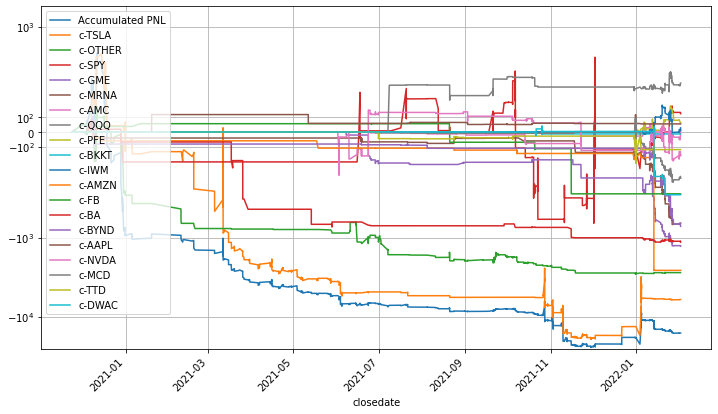

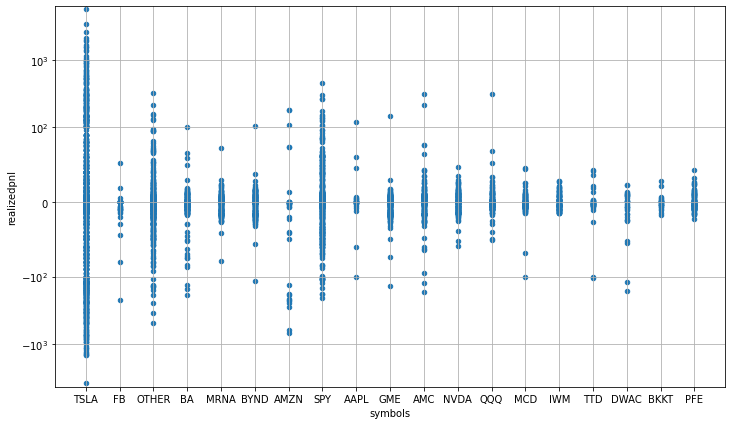

In [63]:
cgr = lambda x: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#print(p2.wdf.columns)

_tmp = ['Accumulated PNL']+['c-'+x for x in p2.stkslcts]
_rtmp = ['r-'+x for x in p2.stkslcts]
#print(p2.wdf[_tmp])
ax = p2.wdf[_tmp].plot(kind="line", rot=45)
plt.grid(b=True, which='major')
ax.set_yscale('symlog', linthreshy=600)
plt.show()


ax = p2.wdf.plot.scatter(x="symbols", y="realizedpnl")
plt.grid(b=True, which='major')
ax.set_yscale('symlog', linthreshy=100)
plt.show()

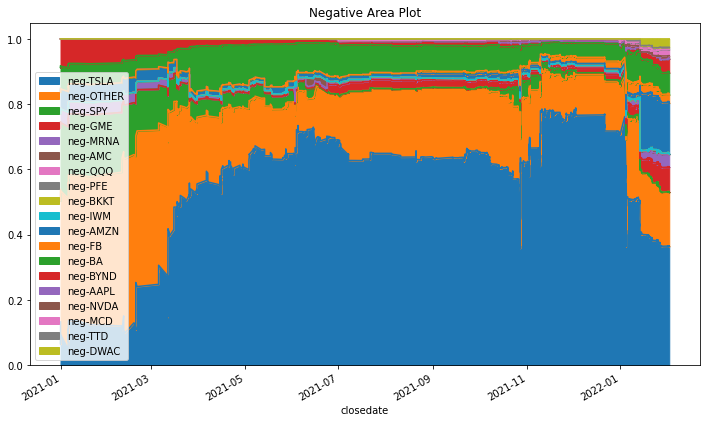

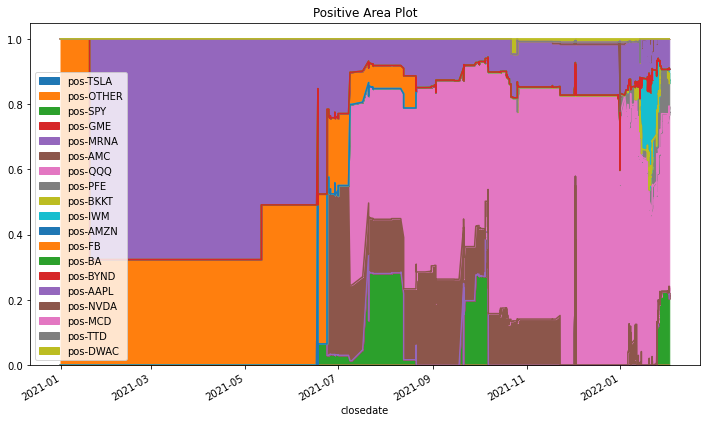

In [72]:
_tmp = ['neg-'+x for x in p2.stkslcts]
data = p2.wdf[_tmp][p2.wdf[_tmp[0].replace('neg-','c-')]<0]
data_perc = data.divide(data.sum(axis=1), axis=0)
data_perc.plot.area(stacked=True)
#plt.stackplot(data_perc[_tmp[0]],  data_perc[_tmp[1]],  data_perc[_tmp[2]], labels=['A','B','C'])
#plt.legend(loc='upper left')
#plt.margins(0,0)
#plt.title('100 % stacked area chart')
plt.title('Negative Area Plot')
plt.show()

_tmp = ['pos-'+x for x in p2.stkslcts]
data = p2.wdf[_tmp][p2.wdf[_tmp[0].replace('pos-','c-')]<0]
data_perc = data.divide(data.sum(axis=1), axis=0)
data_perc.plot.area(stacked=True)
plt.title('Positive Area Plot')
#plt.stackplot(data_perc[_tmp[0]],  data_perc[_tmp[1]],  data_perc[_tmp[2]], labels=['A','B','C'])
#plt.legend(loc='upper left')
#plt.margins(0,0)
#plt.title('100 % stacked area chart')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


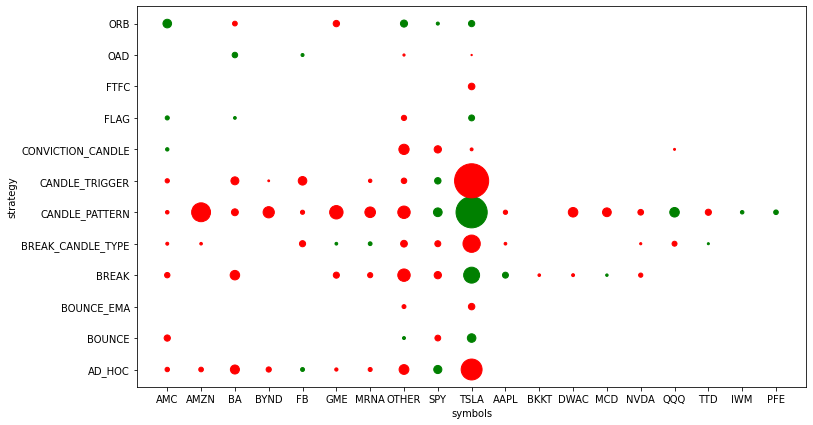

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


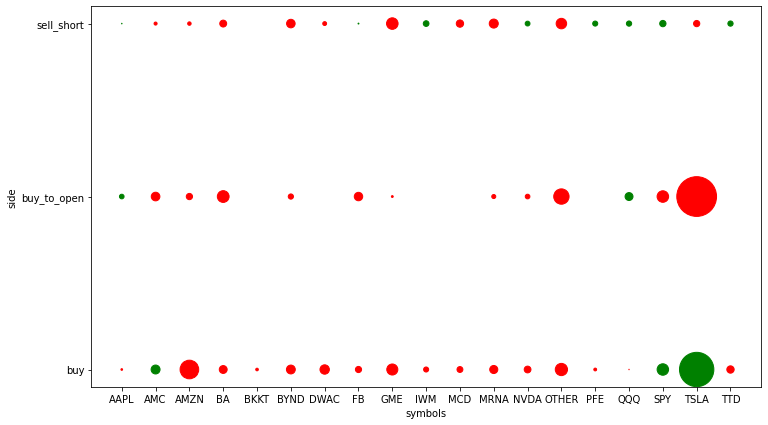

In [57]:

stat = p2.wdf[['strategy','symbols','realizedpnl']].groupby(['strategy','symbols']).sum()
stat['color'] = stat['realizedpnl']
stat['size'] = np.power(np.sqrt(np.abs(stat['realizedpnl'])),1.5)
stat['color'][stat['realizedpnl']>0] = 'Green'
stat['color'][stat['realizedpnl']<=0] = 'Red'
stat.reset_index(inplace=True)
stat.plot.scatter(x="symbols", y="strategy", c='color', s='size')
plt.show()
#stat

stat = p2.wdf[['side','symbols','realizedpnl']].groupby(['side','symbols']).sum()
stat['color'] = stat['realizedpnl']
stat['size'] = np.power(np.sqrt(np.abs(stat['realizedpnl'])),1.5)
stat['color'][stat['realizedpnl']>0] = 'Green'
stat['color'][stat['realizedpnl']<=0] = 'Red'
stat.reset_index(inplace=True)
stat.plot.scatter(x="symbols", y="side", c='color', s='size')
plt.show()